**stage2_DANN_HPsearch.ipynb**. This notebook attempts to search the hyperparameter that yields the optimal validation performance.

**Edit**<br/>

**TODO**<br/>

# Import packages and get authenticated

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 500)
from tqdm import tqdm_notebook as tqdm
from IPython.display import display
import os
import sys
sys.path.append('/content/drive/My Drive/中研院/repo/')
# sys.path.append('~/project_FDDAT/repo/')
sys.path.append('../') # add this line so Data and data are visible in this file
from os.path import expanduser
home = expanduser("~")

from falldetect.utilities import *
from falldetect.models import *
from falldetect.dataset_util import *
from falldetect.training_util import *
from falldetect.eval_util import *

import time
import datetime
from datetime import datetime
import json
import argparse
import copy

# Plotting
# checklist 1: comment inline, uncomment Agg
%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rc( 'savefig', facecolor = 'white' )

# matplotlib.rc( 'savefig', transparent=True )

from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# from torch.utils.data import Dataset, DataLoader

# batch_size = 20
# class_sample_count = [10, 1, 20, 3, 4] # dataset has 10 class-1 samples, 1 class-2 samples, etc.
# weights = 1 / torch.Tensor(class_sample_count)
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)
# trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, sampler = sampler)

# Get user inputs
In ipython notebook, these are hardcoded. In production python code, use parsers to provide these inputs

In [3]:
parser = argparse.ArgumentParser(description='FD_DAT')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')
parser.add_argument('--extractor_type', metavar='extractor_type', help='extractor_type',
                    default='CNN')
parser.add_argument('--num_epochs', type=int, metavar='num_epochs', help='number of epochs',
                    default='5')
parser.add_argument('--CV_n', type=int, metavar='CV_n', help='CV folds',
                    default='2')
parser.add_argument('--rep_n', type=int, metavar='rep_n', help='number of repitition',
                    default='5')
# parser.add_argument('--cuda_i', type=int, metavar='cuda_i', help='cuda index',
#                     default='1')
parser.add_argument('--tasks_list', metavar='tasks_list', help='a list of all tasks',
                    default='UMAFall_waist_UPFall_belt UPFall_wrist_UMAFall_ankle')
parser.add_argument('--show_diagnosis_plt', metavar='show_diagnosis_plt', help='show diagnosis plt or not',
                    default='False')

parser.add_argument('--use_WeightedRandomSampler', metavar='use_WeightedRandomSampler', help='use WeightedRandomSampler to mitigate imbalanced dataset',
                    default='False')


# split_mode = 'LOO'
# split_mode = '5fold'

# checklist 2: comment first line, uncomment second line seizures_FN
# plt.style.use(['dark_background'])
args = parser.parse_args(['--input_folder', '../../data_mic/stage1/preprocessed_18hz_5fold', 
                          '--output_folder', '../../data_mic/stage2/test',
#                           '--training_params_file', 'training_params_list_v1.json',
                          '--training_params_file', 'training_params_list_fixed_revision.json',
#                           '--training_params_file', 'training_params_list_HPsearch.json',
                          '--extractor_type', 'CNN',
                          '--num_epochs', '10',
                          '--CV_n', '2',
                          '--rep_n', '2',
                          '--show_diagnosis_plt', 'True',
                          '--use_WeightedRandomSampler', 'True',
#                           '--tasks_list', 'UMAFall_wrist-UPFall_wrist UPFall_wrist-UMAFall_wrist',])
                          '--tasks_list', 'UMAFall_ankle-UPFall_ankle UMAFall_leg-UPFall_rightpocket UPFall_rightpocket-UMAFall_leg',])
#                           '--tasks_list', 'FARSEEING_thigh-FARSEEING_lowback FARSEEING_lowback-FARSEEING_thigh',])
                          
# args = parser.parse_args()

In [4]:
print(args)

Namespace(input_folder='../../data_mic/stage1/preprocessed_18hz_5fold', output_folder='../../data_mic/stage2/test', training_params_file='training_params_list_fixed_revision.json', extractor_type='CNN', num_epochs=10, CV_n=2, rep_n=2, tasks_list='UMAFall_ankle-UPFall_ankle UMAFall_leg-UPFall_rightpocket UPFall_rightpocket-UMAFall_leg', show_diagnosis_plt='True', use_WeightedRandomSampler='True')


In [5]:
args.show_diagnosis_plt

'True'

In [6]:
home_dir = home+'/project_FDDAT/'
input_folder = args.input_folder
output_folder = args.output_folder
training_params_file = args.training_params_file
extractor_type = args.extractor_type
num_epochs = args.num_epochs
CV_n = args.CV_n
rep_n = args.rep_n
if args.show_diagnosis_plt == 'True':
     show_diagnosis_plt = True
elif args.show_diagnosis_plt == 'False':
     show_diagnosis_plt = False

if args.use_WeightedRandomSampler == 'True':
     use_WeightedRandomSampler = True
elif args.use_WeightedRandomSampler == 'False':
     use_WeightedRandomSampler = False
        
with open('../../repo/falldetect/params.json') as json_file:
    falldetect_params = json.load(json_file)

cuda_i = falldetect_params['cuda_i']

tasks_list = []
for item in args.tasks_list.split(' '):
    tasks_list.append((item.split('-')[0], item.split('-')[1]))
    
inputdir = input_folder+'/'
outputdir = output_folder+'/'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
# test_mode = 'test' in outputdir.split('/')[-2]
# test_mode = 'test' in training_params_file

device = torch.device('cuda:{}'.format(int(cuda_i)) if torch.cuda.is_available() else 'cpu')


# new arch HP search

In [7]:
# training_params_list = [
#   {
#     'HP_name': 'HP_i0',
#     'classes_n': 2,
#     'CV_n': CV_n,
#     'num_epochs': num_epochs,
#     'channel_n': 4,
#     'batch_size': 16,
#     'learning_rate': 0.01,
#     'extractor_type': extractor_type,
# #     'device': device,
#     'dropout': 0.5,
#     'hiddenDim_f': 3,
#     'hiddenDim_y': 3,
#     'hiddenDim_d': 3,
#     'win_size': 18,
#     'win_stride': 6,
#     'step_n': 9,
#     'show_diagnosis_plt': show_diagnosis_plt,
#   },

#   {
#     'HP_name': 'HP_i1',
#     'classes_n': 2,
#     'CV_n': CV_n,
#     'num_epochs': num_epochs,
#     'channel_n': 4,
#     'batch_size': 4,
#     'learning_rate': 0.01,
#     'extractor_type': extractor_type,
# #     'device': device,
#     'dropout': 0.5,
#     'hiddenDim_f': 3,
#     'hiddenDim_y': 3,
#     'hiddenDim_d': 3,
#     'win_size': 18,
#     'win_stride': 6,
#     'step_n': 9,
#     'show_diagnosis_plt': show_diagnosis_plt,
#   },

#   {
#     'HP_name': 'HP_i2',
#     'classes_n': 2,
#     'CV_n': CV_n,
#     'num_epochs': num_epochs,
#     'channel_n': 4,
#     'batch_size': 64,
#     'learning_rate': 0.01,
#     'extractor_type': extractor_type,
# #     'device': device,
#     'dropout': 0.5,
#     'hiddenDim_f': 3,
#     'hiddenDim_y': 3,
#     'hiddenDim_d': 3,
#     'win_size': 18,
#     'win_stride': 6,
#     'step_n': 9,
#     'show_diagnosis_plt': show_diagnosis_plt,
#   },
    
#   {
#     'HP_name': 'HP_i3',
#     'classes_n': 2,
#     'CV_n': CV_n,
#     'num_epochs': num_epochs,
#     'channel_n': 16,
#     'batch_size': 4,
#     'learning_rate': 0.01,
#     'extractor_type': extractor_type,
# #     'device': device,
#     'dropout': 0.5,
#     'hiddenDim_f': 3,
#     'hiddenDim_y': 3,

#     'hiddenDim_d': 3,
#     'win_size': 18,
#     'win_stride': 6,
#     'step_n': 9,
#     'show_diagnosis_plt': show_diagnosis_plt,
#   },

#   {
#     'HP_name': 'HP_i4',
#     'classes_n': 2,
#     'CV_n': CV_n,
#     'num_epochs': num_epochs,
#     'channel_n': 32,
#     'batch_size': 4,
#     'learning_rate': 0.01,
#     'extractor_type': extractor_type,
# #     'device': device,
#     'dropout': 0.5,
#     'hiddenDim_f': 3,
#     'hiddenDim_y': 3,
#     'hiddenDim_d': 3,
#     'win_size': 18,
#     'win_stride': 6,
#     'step_n': 9,
#     'show_diagnosis_plt': show_diagnosis_plt,
#   },

#   {
#     'HP_name': 'HP_i5',
#     'classes_n': 2,
#     'CV_n': CV_n,
#     'num_epochs': num_epochs,
#     'channel_n': 4,
#     'batch_size': 4,
#     'learning_rate': 0.001,
#     'extractor_type': extractor_type,
# #     'device': device,
#     'dropout': 0.5,
#     'hiddenDim_f': 3,
#     'hiddenDim_y': 3,
#     'hiddenDim_d': 3,
#     'win_size': 18,
#     'win_stride': 6,
#     'step_n': 9,
#     'show_diagnosis_plt': show_diagnosis_plt,
#   },

#   {
#     'HP_name': 'HP_i6',
#     'classes_n': 2,
#     'CV_n': CV_n,
#     'num_epochs': num_epochs,
#     'channel_n': 4,
#     'batch_size': 4,
#     'learning_rate': 0.0001,
#     'extractor_type': extractor_type,
# #     'device': device,
#     'dropout': 0.5,
#     'hiddenDim_f': 3,
#     'hiddenDim_y': 3,
#     'hiddenDim_d': 3,
#     'win_size': 18,
#     'win_stride': 6,
#     'step_n': 9,
#     'show_diagnosis_plt': show_diagnosis_plt,
#   }, ]

# with open('training_params_list.json', 'w') as fout:
#     json.dump(training_params_list, fout, indent=2)

In [8]:
with open(training_params_file) as json_file:
    training_params_list = json.load(json_file)
    
for training_params in training_params_list:
    training_params['CV_n'] = CV_n
    training_params['rep_n'] = rep_n
#     training_params['CV_list'] = CV_list
    training_params['num_epochs'] = num_epochs
    training_params['extractor_type'] = extractor_type
    training_params['device'] = device
    training_params['show_diagnosis_plt'] = show_diagnosis_plt
    training_params['use_WeightedRandomSampler'] = use_WeightedRandomSampler
    
    


In [11]:
training_params

{'HP_name': 'HP_fixed',
 'classes_n': 2,
 'channel_n': 4,
 'batch_size': 4,
 'learning_rate': 0.001,
 'λ': 1,
 'dropout': 0.5,
 'show_diagnosis_plt': True,
 'use_WeightedRandomSampler': True,
 'ADL_only': True,
 'CV_n': 2,
 'rep_n': 2,
 'num_epochs': 10,
 'extractor_type': 'CNN',
 'device': device(type='cuda', index=0)}

In [9]:
def run_rep(df_metric_keys, tgt_name, training_params, inputdir, task_outputdir, rep_n=5):
    # 5. run rep experiments
    df_sample = pd.DataFrame('', index=['channel_n', 'batch_size', 'learning_rate', 
                                        'source', 'DANN', 'target', 'domain', 'time_elapsed', 'num_params', 'PAD_source', 'PAD_DANN'], columns=[])
    df_dict_agg_rep = dict( zip(df_metric_keys,[df_sample.copy(), df_sample.copy(), df_sample.copy(), df_sample.copy()]))

    for i_rep in range(rep_n):
        df_dict = performance_table(src_name, tgt_name, training_params, i_rep, inputdir, task_outputdir+training_params['HP_name']+'/')

        for df_name in df_dict_agg_rep.keys():
            df_dict_agg_rep[df_name]['rep{}'.format(i_rep)] = df_dict[df_name].copy()

    df_outputdir = task_outputdir+training_params['HP_name']+'/'
#     task_outputdir+'repetitive_results/'
    if not os.path.exists(df_outputdir):
        os.makedirs(df_outputdir)
    print('df_dict_agg_rep saved at', df_outputdir)

    for df_name in df_dict_agg_rep.keys():
        df_dict_agg_rep[df_name] = get_rep_stats(df_dict_agg_rep[df_name], rep_n)
        df_dict_agg_rep[df_name].to_csv(df_outputdir+'df_performance_table_agg_rep_{}.csv'.format(df_name.split('_')[1]), encoding='utf-8')

    return df_dict_agg_rep

outputdir for stage2 ('UMAFall_ankle', 'UPFall_ankle') output: ../../data_mic/stage2/test/UMAFall_ankle_UPFall_ankle/

======================  train on source, val on target(source=UMAFall_ankle to target=UPFall_ankle)  ======================

------------------------------Working on i_CV 0------------------------------
Working on get_data_loader for ['UMAFall', 'ankle']...
train_data shape: (268, 3, 66) [173:95]
val_data shape: (115, 3, 66) [75:40]
counts for labels [173, 95]
weights for labels tensor([0.3545, 0.6455])
Working on get_data_loader for ['UPFall', 'ankle']...
train_data shape: (428, 3, 66) [234:194]
val_data shape: (130, 3, 66) [70:60]
counts for labels [234, 194]
weights for labels tensor([0.4533, 0.5467])
outputdir for model_output_diagnosis_trainval output: ../../data_mic/stage2/test/UMAFall_ankle_UPFall_ankle/HP_fixed/source/rep0/


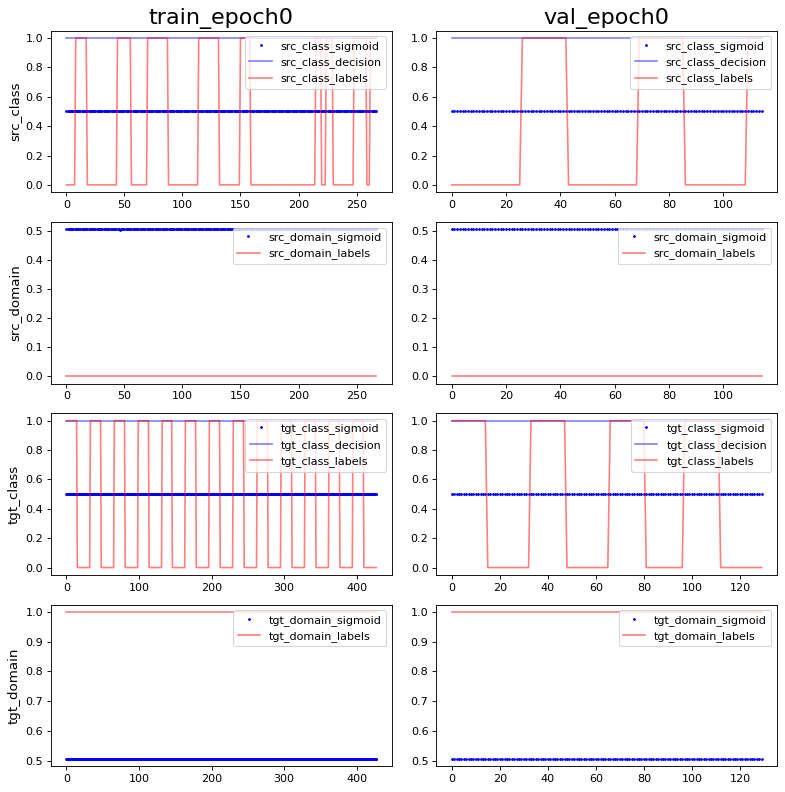

outputdir for model_features_diagnosis_trainval output: ../../data_mic/stage2/test/UMAFall_ankle_UPFall_ankle/HP_fixed/source/rep0/
show standardize mean and std: -1.9183104e-09 0.70710677
(696, 40) (696, 2)
show standardize mean and std: 1.5570193e-09 0.70710677
(245, 40) (245, 2)


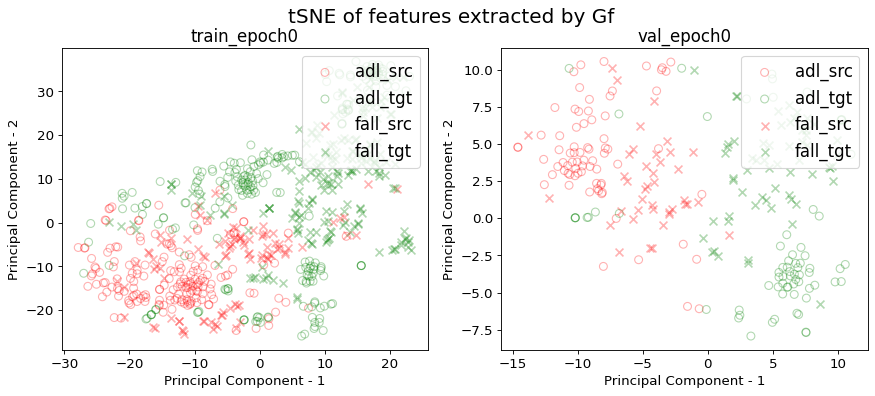

tensor([False, False, False,  True], device='cuda:0') tensor([False,  True,  True, False], device='cuda:0')
tensor(0.9742, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.4777, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.4520, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.6175, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.6175, device='cuda:0', grad_fn=<NllLossBackward>)
tensor([ True,  True,  True, False], device='cuda:0') tensor([ True,  True,  True, False], device='cuda:0')
tensor(1.1343, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.4737, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.6081, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward>)
tensor([False, False,  True, False], device='cuda:0') tensor([ True, False,  True,  True], device='cuda:0')
tensor(0.7388, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.5280, device='cuda:0', g

KeyboardInterrupt: 

In [10]:
# fine-tuning
df_metric_keys = ['df_acc', 'df_sensitivity', 'df_specificity', 'df_precision', 'df_F1']

for task_item in tasks_list:
    (src_name, tgt_name) = task_item

    task_outputdir = '{}{}_{}/'.format(outputdir, src_name, tgt_name)
    if not os.path.exists(task_outputdir):
        os.makedirs(task_outputdir)
    print('outputdir for stage2 {} output: {}'.format(task_item, task_outputdir))

    df_sample = pd.DataFrame('', index=['channel_n', 'batch_size', 'learning_rate', 
                                              'source', 'DANN', 'target', 'domain', 'time_elapsed', 'num_params', 'PAD_source', 'PAD_DANN'], columns=[])
    df_dict_agg_HP = dict( zip(df_metric_keys,[df_sample.copy(), df_sample.copy(), df_sample.copy(), df_sample.copy(), df_sample.copy()]))

    # 1. try all HP
    for i, training_params in enumerate(training_params_list):
        df_dict_agg_rep = run_rep(df_metric_keys, tgt_name, training_params, inputdir, task_outputdir, rep_n)
        training_params['df_dict_agg_rep'] = copy.deepcopy(df_dict_agg_rep)

        for df_name in df_dict_agg_rep.keys():
            print('show', df_name)
            display(df_dict_agg_rep[df_name])
            

In [ ]:
# def get_rep_stats2(df_performance_table_agg, rep_n):
# 	df_acc = df_performance_table_agg.loc[ ['source', 'DANN', 'target', 'domain', 'PAD_source', 'PAD_DANN'] , ].copy()
# 	df_params = df_performance_table_agg.loc[ ['channel_n', 'batch_size', 'learning_rate', 'time_elapsed', 'num_params'], ].copy()

#     # accs
# 	df_performance_table_all_mean = df_acc.applymap(get_mean)
# 	df_performance_table_means = df_performance_table_all_mean.mean(axis=1)
# 	df_performance_table_stds = df_performance_table_all_mean.std(axis=1)
# 	df_performance_table_all_mean['mean'] = df_performance_table_means
# 	df_performance_table_all_mean['std'] = df_performance_table_stds
# 	df_performance_table_all_mean['rep'] = df_performance_table_all_mean[['mean', 'std']].apply(lambda x : '{:.3f}±{:.3f}'.format(x[0],x[1]), axis=1)

#     # params
# 	df_params_means = df_params.mean(axis=1)

# 	df_performance_table_agg['rep_avg'] = ''
# 	df_performance_table_agg.loc[ ['source','DANN','target','domain','PAD_source','PAD_DANN'] , ['rep_avg']] = df_performance_table_all_mean.loc[:, 'rep']
# 	df_performance_table_agg.loc[ ['channel_n','batch_size','learning_rate','time_elapsed','num_params'], ['rep_avg']] = df_params_means
# 	return df_performance_table_agg

# get_rep_stats2(df_dict_agg_rep[df_name], rep_n)

In [ ]:
# precision=np.asarray(range(100))/100
# sensitivity=np.asarray(range(100))/100
# F1 = 2 * (precision * sensitivity) / (precision + sensitivity)
# F1
# # plt.plot(np.asarray(range(100))/100, F1)